#GATHER DATA

In [1]:
#calling important libraries that genraly in need
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime

In [2]:
#read the files of data in data frames we have three diffrent file in three diffrent format
#First file twitter archive enhnced and it was in csv and that is fine for panadas
#Second file tweet json also can be read directly in data frame
#third file image predections was in tsv foramt and I used excel to convert its format to csv
 
archive=pd.read_csv('/content/twitter-archive-enhanced.csv')
tweet=pd.read_json('/content/tweet-json copy.json',lines=True)
image=pd.read_csv('/content/image-predictions-3.csv')


# Assement

view data

In [3]:
archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [4]:
tweet

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status
0,2017-08-01 16:23:56+00:00,892420643555336193,892420643555336192,This is Phineas. He's a mystical boy. Only eve...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,NaN,None,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN,None,NaN,False,8853,39467,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
1,2017-08-01 00:17:27+00:00,892177421306343426,892177421306343424,This is Tilly. She's just checking pup on you....,False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,NaN,None,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN,None,NaN,False,6514,33819,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
2,2017-07-31 00:18:03+00:00,891815181378084864,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,False,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,NaN,None,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN,None,NaN,False,4328,25461,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
3,2017-07-30 15:58:51+00:00,891689557279858688,891689557279858688,This is Darla. She commenced a snooze mid meal...,False,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,NaN,None,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN,None,NaN,False,8964,42908,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
4,2017-07-29 16:00:24+00:00,891327558926688256,891327558926688256,This is Franklin. He would like you to stop ca...,False,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,NaN,None,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN,None,NaN,False,9774,41048,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2349,2015-11-16 00:24:50+00:00,666049248165822465,666049248165822464,Here we have a 1949 1st generation vulpix. Enj...,False,"[0, 120]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666049244999131136, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,NaN,None,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN,None,NaN,False,41,111,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
2350,2015-11-16 00:04:52+00:00,666044226329800704,666044226329800704,This is a purebred Piers Morgan. Loves to Netf...,False,"[0, 137]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666044217047650304, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,NaN,None,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN,None,NaN,False,147,311,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
2351,2015-11-15 23:21:54+00:00,666033412701032449,666033412701032448,Here is a very happy pup. Big fan of well-main...,False,"[0, 130]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666033409081393153, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,NaN,None,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN,No

In [5]:
image

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,6.660210e+17,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,6.660290e+17,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,6.660330e+17,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,6.660440e+17,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,6.660490e+17,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,8.913280e+17,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,8.916900e+17,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,8.918150e+17,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,8.921770e+17,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


Shape of data

In [6]:
archive.shape

(2356, 17)

In [7]:
tweet.shape

(2354, 31)

In [8]:
image.shape

(2075, 12)

names of column




In [9]:
archive.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

In [10]:
tweet.columns

Index(['created_at', 'id', 'id_str', 'full_text', 'truncated',
       'display_text_range', 'entities', 'extended_entities', 'source',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str',
       'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place',
       'contributors', 'is_quote_status', 'retweet_count', 'favorite_count',
       'favorited', 'retweeted', 'possibly_sensitive',
       'possibly_sensitive_appealable', 'lang', 'retweeted_status',
       'quoted_status_id', 'quoted_status_id_str', 'quoted_status'],
      dtype='object')

In [11]:
image.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')


*   see the info of the data. 

*   we can no variable data_type and variable contains null values.




In [12]:
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [13]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   created_at                     2354 non-null   datetime64[ns, UTC]
 1   id                             2354 non-null   int64              
 2   id_str                         2354 non-null   int64              
 3   full_text                      2354 non-null   object             
 4   truncated                      2354 non-null   bool               
 5   display_text_range             2354 non-null   object             
 6   entities                       2354 non-null   object             
 7   extended_entities              2073 non-null   object             
 8   source                         2354 non-null   object             
 9   in_reply_to_status_id          78 non-null     float64            
 10  in_reply_to_status_id_st

In [14]:
image.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   float64
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(4), int64(1), object(4)
memory usage: 152.1+ KB


have a glance over numeric variables' values


In [15]:
archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [16]:
tweet.describe()

,id,id_str,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,geo,coordinates,contributors,retweet_count,favorite_count,possibly_sensitive,possibly_sensitive_appealable,quoted_status_id,quoted_status_id_str
count,2.354000e+03,2.354000e+03,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,0.0,0.0,0.0,2354.000000,2354.000000,2211.0,2211.0,2.900000e+01,2.900000e+01
mean,7.426978e+17,7.426978e+17,7.455079e+17,7.455079e+17,2.014171e+16,2.014171e+16,NaN,NaN,NaN,3164.797366,8080.968564,0.0,0.0,8.162686e+17,8.162686e+17
std,6.852812e+16,6.852812e+16,7.582492e+16,7.582492e+16,1.252797e+17,1.252797e+17,NaN,NaN,NaN,5284.770364,11814.771334,0.0,0.0,6.164161e+16,6.164161e+16
min,6.660209e+17,6.660209e+17,6.658147e+17,6.658147e+17,1.185634e+07,1.185634e+07,NaN,NaN,NaN,0.000000,0.000000,0.0,0.0,6.721083e+17,6.721083e+17
25%,6.783975e+17,6.783975e+17,6.757419e+17,6.757419e+17,3.086374e+08,3.086374e+08,NaN,NaN,NaN,624.500000,1415.000000,0.0,0.0,7.888183e+17,7.888183e+17
50%,7.194596e+17,7.194596e+17,7.038708e+17,7.038708e+17,4.196984e+09,4.196984e+09,NaN,NaN,NaN,1473.500000,3603.500000,0.0,0.0,8.340867e+17,8.340867e+17
75%,7.993058e+17,7.993058e+17,8.257804e+17,8.257804e+17,4.196984e+09,4.196984e+09,NaN,NaN,NaN,3652.000000,10122.250000,0.0,0.0,8.664587e+17,8.664587e+17
max,8.924206e+17,8.924206e+17,8.862664e+17,8.862664e+17,8.405479e+17,8.405479e+17,NaN,NaN,NaN,79515.000000,132810.000000,0.0,0.0,8.860534e+17,8.860534e+17


In [17]:
image.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785204e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660210e+17,1.000000,0.044333,1.010000e-08,1.740000e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119990e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932035e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924210e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


check if there any duplicated data

In [18]:
archive.duplicated().sum()

0

In [19]:
archive['tweet_id'].duplicated().sum()

0

In [20]:
tweet.astype(str).duplicated().sum()

0

In [21]:
tweet['id'].astype(str).duplicated().sum()

0

In [22]:
image['tweet_id'].duplicated().sum()

4

check some specific varibles 

In [23]:
archive.expanded_urls.unique()

array(['https://twitter.com/dog_rates/status/892420643555336193/photo/1',
       'https://twitter.com/dog_rates/status/892177421306343426/photo/1',
       'https://twitter.com/dog_rates/status/891815181378084864/photo/1',
       ...,
       'https://twitter.com/dog_rates/status/666033412701032449/photo/1',
       'https://twitter.com/dog_rates/status/666029285002620928/photo/1',
       'https://twitter.com/dog_rates/status/666020888022790149/photo/1'],
      dtype=object)

In [24]:
archive.name.value_counts()

None           745
a               55
Charlie         12
Oliver          11
Cooper          11
              ... 
Opie             1
infuriating      1
Leonidas         1
Edmund           1
Laela            1
Name: name, Length: 957, dtype: int64

In [25]:
tweet.lang.value_counts()

en     2336
und       7
nl        3
in        3
tl        1
es        1
ro        1
eu        1
et        1
Name: lang, dtype: int64

In [26]:
tweet.possibly_sensitive.value_counts()

0.0    2211
Name: possibly_sensitive, dtype: int64

In [27]:
tweet.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2219
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

null values

In [28]:
archive.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [29]:
tweet.isnull().sum()

created_at                          0
id                                  0
id_str                              0
full_text                           0
truncated                           0
display_text_range                  0
entities                            0
extended_entities                 281
source                              0
in_reply_to_status_id            2276
in_reply_to_status_id_str        2276
in_reply_to_user_id              2276
in_reply_to_user_id_str          2276
in_reply_to_screen_name          2276
user                                0
geo                              2354
coordinates                      2354
place                            2353
contributors                     2354
is_quote_status                     0
retweet_count                       0
favorite_count                      0
favorited                           0
retweeted                           0
possibly_sensitive                143
possibly_sensitive_appealable     143
lang        

In [30]:
image.isnull().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

Quality
- Time stamp is in object format, whcich should be in datetime format.
- in_reply_to_status_id has just 78 non-null as well as in_reply_to_user_id which not likely to be solved! also retweeted_status_id 181 non-null and   retweeted_status_user_id.
- numenator is greater than 10 which is maximum rate!
- some unwanted data are in 
- doggo, pupper,puppo,floofer variables are object data type which should be string.
-Name column has "NONE" as a value which mean it has nulls "missing data".
- predection table has four id dublicates.
- many null values in tweets table.
- tweet data id has different name than image and archive whcich should be the same name.

Tidiness: 
*   dog types are in four seprate column which ahould be one column.
*   full text column is duplicated in the three tabels







#clean

timestamp data type

In [31]:
archive['timestamp'] = pd.to_datetime(archive['timestamp'])

drop columns with much null values

In [32]:
archive=archive.drop(['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp'],axis=1)
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2356 non-null   int64              
 1   timestamp           2356 non-null   datetime64[ns, UTC]
 2   source              2356 non-null   object             
 3   text                2356 non-null   object             
 4   expanded_urls       2297 non-null   object             
 5   rating_numerator    2356 non-null   int64              
 6   rating_denominator  2356 non-null   int64              
 7   name                2356 non-null   object             
 8   doggo               2356 non-null   object             
 9   floofer             2356 non-null   object             
 10  pupper              2356 non-null   object             
 11  puppo               2356 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(3

In [33]:
tweet=tweet.drop(columns=['in_reply_to_status_id','in_reply_to_status_id_str','in_reply_to_user_id',
                          'in_reply_to_user_id_str','in_reply_to_screen_name','user','geo' ,                             
                          'coordinates', 'place','contributors' ,'is_quote_status' ,  'possibly_sensitive',
                          'possibly_sensitive_appealable','retweeted_status','quoted_status_id',
                          'quoted_status_id_str','quoted_status'         ])
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   created_at          2354 non-null   datetime64[ns, UTC]
 1   id                  2354 non-null   int64              
 2   id_str              2354 non-null   int64              
 3   full_text           2354 non-null   object             
 4   truncated           2354 non-null   bool               
 5   display_text_range  2354 non-null   object             
 6   entities            2354 non-null   object             
 7   extended_entities   2073 non-null   object             
 8   source              2354 non-null   object             
 9   retweet_count       2354 non-null   int64              
 10  favorite_count      2354 non-null   int64              
 11  favorited           2354 non-null   bool               
 12  retweeted           2354 non-null 

drop dublicates

In [34]:
image=image.drop_duplicates(subset=['tweet_id'])
image['tweet_id'].duplicated().sum()


0

group dog type in one column 

 hint the type was not string but used .str method to solve this problem.





In [35]:
archive['puppo'].value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

In [36]:
archive['floofer'].value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [37]:
archive['pupper'].value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [38]:
archive['doggo'].value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [39]:
# dog_type=pd.DataFrame(data=[archive['doggo'],archive['floofer'],archive['pupper'],archive['puppo']])
# dog_type=dog_type.T

In [40]:
archive=archive[(archive['doggo']=="doggo") | (archive['floofer']=="floofer") | (archive['puppo']=="puppo" )| (archive['pupper']=='pupper')]    

In [41]:
archive['type'] =pd.DataFrame( archive['puppo']+archive['floofer']+archive['pupper']+archive['doggo'])

In [42]:
archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380 entries, 9 to 2017
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            380 non-null    int64              
 1   timestamp           380 non-null    datetime64[ns, UTC]
 2   source              380 non-null    object             
 3   text                380 non-null    object             
 4   expanded_urls       374 non-null    object             
 5   rating_numerator    380 non-null    int64              
 6   rating_denominator  380 non-null    int64              
 7   name                380 non-null    object             
 8   doggo               380 non-null    object             
 9   floofer             380 non-null    object             
 10  pupper              380 non-null    object             
 11  puppo               380 non-null    object             
 12  type                380 non-null   

In [43]:
archive['type']=archive['type'].str.replace("None","")


In [44]:
archive.type.value_counts()

pupper          245
doggo            83
puppo            29
pupperdoggo      12
floofer           9
flooferdoggo      1
puppodoggo        1
Name: type, dtype: int64

In [45]:
archive=pd.DataFrame(archive[ archive.type.isin(["","puppodoggo","pupperdoggo","flooferdoggo"])==False   ])

In [46]:
archive.type.value_counts()

pupper     245
doggo       83
puppo       29
floofer      9
Name: type, dtype: int64

In [47]:
archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 9 to 2017
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            366 non-null    int64              
 1   timestamp           366 non-null    datetime64[ns, UTC]
 2   source              366 non-null    object             
 3   text                366 non-null    object             
 4   expanded_urls       360 non-null    object             
 5   rating_numerator    366 non-null    int64              
 6   rating_denominator  366 non-null    int64              
 7   name                366 non-null    object             
 8   doggo               366 non-null    object             
 9   floofer             366 non-null    object             
 10  pupper              366 non-null    object             
 11  puppo               366 non-null    object             
 12  type                366 non-null   

drop unwanted columns

In [48]:
archive=archive.drop(columns=['source','text','expanded_urls','name','doggo','floofer','pupper','puppo'])
archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 9 to 2017
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            366 non-null    int64              
 1   timestamp           366 non-null    datetime64[ns, UTC]
 2   rating_numerator    366 non-null    int64              
 3   rating_denominator  366 non-null    int64              
 4   type                366 non-null    object             
dtypes: datetime64[ns, UTC](1), int64(3), object(1)
memory usage: 17.2+ KB


In [49]:
tweet=tweet.drop(columns=['id_str','full_text','truncated','display_text_range','entities','extended_entities','source'])
tweet.info()
    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   created_at      2354 non-null   datetime64[ns, UTC]
 1   id              2354 non-null   int64              
 2   retweet_count   2354 non-null   int64              
 3   favorite_count  2354 non-null   int64              
 4   favorited       2354 non-null   bool               
 5   retweeted       2354 non-null   bool               
 6   lang            2354 non-null   object             
dtypes: bool(2), datetime64[ns, UTC](1), int64(3), object(1)
memory usage: 96.7+ KB


make maximum nuerator 10

In [50]:
archive.describe()

,tweet_id,rating_numerator,rating_denominator
count,3.660000e+02,366.000000,366.0
mean,7.493634e+17,11.210383,10.0
std,6.405710e+16,1.896500,0.0
min,6.721600e+17,3.000000,10.0
25%,6.873533e+17,10.000000,10.0
50%,7.425000e+17,11.000000,10.0
75%,8.010604e+17,12.000000,10.0
max,8.902403e+17,27.000000,10.0


In [51]:
archive['rating_numerator']=archive['rating_numerator'].where(archive['rating_numerator']<10,10)

In [52]:
archive

,tweet_id,timestamp,rating_numerator,rating_denominator,type
9,890240255349198849,2017-07-26 15:59:51+00:00,10,10,doggo
12,889665388333682689,2017-07-25 01:55:32+00:00,10,10,puppo
14,889531135344209921,2017-07-24 17:02:04+00:00,10,10,puppo
29,886366144734445568,2017-07-15 23:25:31+00:00,10,10,pupper
43,884162670584377345,2017-07-09 21:29:42+00:00,10,10,doggo
...,...,...,...,...,...
1995,672594978741354496,2015-12-04 01:55:13+00:00,9,10,pupper
2002,672481316919734272,2015-12-03 18:23:34+00:00,10,10,pupper
2009,672254177670729728,2015-12-03 03:21:00+00:00,10,10,pupper
2015,672205392827572224,2015-12-03 00:07:09+00:00,9,10,pupper


In [53]:
archive.describe()

,tweet_id,rating_numerator,rating_denominator
count,3.660000e+02,366.000000,366.0
mean,7.493634e+17,9.737705,10.0
std,6.405710e+16,0.802086,0.0
min,6.721600e+17,3.000000,10.0
25%,6.873533e+17,10.000000,10.0
50%,7.425000e+17,10.000000,10.0
75%,8.010604e+17,10.000000,10.0
max,8.902403e+17,10.000000,10.0


rename tweet id for tweet dataframe

In [54]:
tweet=tweet.rename(columns={'id':'tweet_id'})

In [55]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   created_at      2354 non-null   datetime64[ns, UTC]
 1   tweet_id        2354 non-null   int64              
 2   retweet_count   2354 non-null   int64              
 3   favorite_count  2354 non-null   int64              
 4   favorited       2354 non-null   bool               
 5   retweeted       2354 non-null   bool               
 6   lang            2354 non-null   object             
dtypes: bool(2), datetime64[ns, UTC](1), int64(3), object(1)
memory usage: 96.7+ KB


#storing, analyzing and visualising

first group all data in one data frame to store

In [56]:
df = pd.concat([archive,tweet,image],axis=1,join='inner')

In [57]:
df

,tweet_id,timestamp,rating_numerator,rating_denominator,type,created_at,tweet_id,retweet_count,favorite_count,favorited,retweeted,lang,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
9,890240255349198849,2017-07-26 15:59:51+00:00,10,10,doggo,2017-07-26 15:59:51+00:00,890240255349198849,7711,32467,False,False,en,6.660590e+17,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True
12,889665388333682689,2017-07-25 01:55:32+00:00,10,10,puppo,2017-07-25 01:55:32+00:00,889665388333682689,8538,38818,False,False,en,6.660730e+17,https://pbs.twimg.com/media/CT5d9DZXAAALcwe.jpg,1,Walker_hound,0.260857,True,English_foxhound,0.175382,True,Ibizan_hound,0.097471,True
14,889531135344209921,2017-07-24 17:02:04+00:00,10,10,puppo,2017-07-24 17:02:04+00:00,889531135344209921,2321,15359,False,False,en,6.660940e+17,https://pbs.twimg.com/media/CT5w9gUW4AAsBNN.jpg,1,bloodhound,0.195217,True,German_shepherd,0.078260,True,malinois,0.075628,True
29,886366144734445568,2017-07-15 23:25:31+00:00,10,10,pupper,2017-07-15 16:51:35+00:00,886267009285017600,4,117,False,False,en,6.664120e+17,https://pbs.twimg.com/media/CT-RugiWIAELEaq.jpg,1,coho,0.404640,False,barracouta,0.271485,False,gar,0.189945,False
43,884162670584377345,2017-07-09 21:29:42+00:00,10,10,doggo,2017-07-09 00:00:04+00:00,883838122936631299,3586,22349,False,False,en,6.667770e+17,https://pbs.twimg.com/media/CUDeDoWUYAAD-EM.jpg,1,seat_belt,0.375057,False,miniature_pinscher,0.167175,True,Chihuahua,0.086951,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,672594978741354496,2015-12-04 01:55:13+00:00,9,10,pupper,2015-12-04 01:40:29+00:00,672591271085670400,207,782,False,False,en,8.742970e+17,https://pbs.twimg.com/media/DCIgSR0XgAANEOY.jpg,1,cocker_spaniel,0.437216,True,miniature_poodle,0.277191,True,toy_poodle,0.157402,True
2002,672481316919734272,2015-12-03 18:23:34+00:00,10,10,pupper,2015-12-03 17:23:00+00:00,672466075045466113,598,1447,False,False,en,8.768380e+17,https://pbs.twimg.com/media/DCsnnZsVwAEfkyi.jpg,1,bloodhound,0.575751,True,redbone,0.240970,True,Tibetan_mastiff,0.088935,True
2009,672254177670729728,2015-12-03 03:21:00+00:00,10,10,pupper,2015-12-03 02:45:32+00:00,672245253877968896,169,733,False,False,en,8.782820e+17,https://pbs.twimg.com/media/DDBIX9QVYAAohGa.jpg,1,basset,0.320420,True,collie,0.215975,True,Appenzeller,0.128507,True
2015,672205392827572224,2015-12-03 00:07:09+00:00,9,10,pupper,2015-12-02 21:06:56+00:00,672160042234327040,395,918,False,False,en,8.794920e+17,https://pbs.twimg.com/media/DDSVWMvXsAEgmMK.jpg,1,German_short-haired_pointer,0.479896,True,vizsla,0.124353,True,bath_towel,0.073320,False


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364 entries, 9 to 2017
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            364 non-null    int64              
 1   timestamp           364 non-null    datetime64[ns, UTC]
 2   rating_numerator    364 non-null    int64              
 3   rating_denominator  364 non-null    int64              
 4   type                364 non-null    object             
 5   created_at          364 non-null    datetime64[ns, UTC]
 6   tweet_id            364 non-null    int64              
 7   retweet_count       364 non-null    int64              
 8   favorite_count      364 non-null    int64              
 9   favorited           364 non-null    bool               
 10  retweeted           364 non-null    bool               
 11  lang                364 non-null    object             
 12  tweet_id            364 non-null   

In [59]:
df.to_csv('/content/drive/MyDrive/twitter_archive_master.csv')

first inshight "Which dog type is the most common"

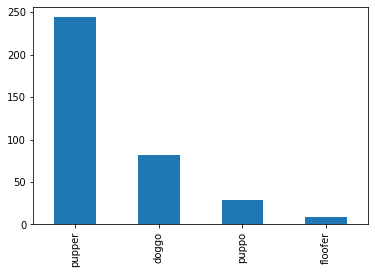

In [60]:
df['type'].value_counts().plot(kind='bar')

second insghit "which type has maximum retweets"

In [61]:
pd.DataFrame(df.groupby('type')['retweet_count'].sum())


,retweet_count
type,
doggo,441571
floofer,28720
pupper,680624
puppo,162060


third "which year has most active"

In [62]:
df['created_at'] = pd.to_datetime(df['created_at'])
df['Year']=df['created_at'].apply(lambda x: x.year)
df['Year'].value_counts()

2016    219
2017     79
2015     66
Name: Year, dtype: int64